In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


# Data

Two datasets- **Hourly** apple performances and **Daily** apple performances

 

In [132]:
## Loading data and sorting

apple_df = pd.read_csv('/kaggle/input/apple-dataset/AAPL_Hourly_5MIN_2024_12_12_2025_01_10.csv')
apple_df.rename(columns = {'Unnamed: 0': 'Datetime'},inplace = True)
apple_df['Datetime'] = pd.to_datetime(apple_df['Datetime'])
apple_df['Return'] = apple_df['Close'] - apple_df['Close'].shift(1)
apple_df['LogReturn'] = np.log(apple_df['Close'] / apple_df['Close'].shift(1))
apple_df = apple_df.dropna()

## Setting Train and Test

n = apple_df.shape[0]
apple_train = apple_df.iloc[:int(np.ceil(n*0.7))]
apple_test = apple_df.iloc[int(np.ceil(n*0.7)):]
train_subset = apple_train[['Datetime','Close']]
test_subset = apple_test[['Datetime','Close']]

In [133]:
## Loading data and sorting

apple_intra_df = pd.read_csv('/kaggle/input/apple-intra/AAPL_2015_2024_newest.csv')
apple_intra_df.rename(columns = {'Unnamed: 0': 'Datetime'},inplace = True)
apple_intra_df['Datetime'] = pd.to_datetime(apple_intra_df['Datetime'])
apple_intra_df['Return'] = apple_intra_df['Close_daily'] - apple_intra_df['Close_daily'].shift(1)
apple_intra_df['LogReturn'] = np.log(apple_intra_df['Close_daily'] / apple_intra_df['Close_daily'].shift(1))
apple_intra_df = apple_intra_df.dropna()

## Setting Train and Test

n = apple_intra_df.shape[0]
apple_train_intra = apple_intra_df.iloc[:int(np.ceil(n*0.7))]
apple_test_intra = apple_intra_df.iloc[int(np.ceil(n*0.7)):]
train_subset_intra = apple_train_intra[['Datetime','Return']]
test_subset_intra = apple_test_intra[['Datetime','Return']]

In [134]:
## Loading data and sorting

weather_df = pd.read_csv('/kaggle/input/weather-over-time/reshaped_weather_data.csv')
isr_df = weather_df[weather_df['Country'] == "Israel"]
isr_df['Date'] = pd.to_datetime(isr_df['Date'])
n = isr_df.shape[0]
isr_train = isr_df.iloc[:int(np.ceil(n*0.85))]
isr_test = isr_df.iloc[int(np.ceil(n*0.85)):]
isr_train_subset = isr_train[['Date','Value']]
isr_test_subset = isr_test[['Date','Value']]



In [135]:
isr_df.head()

,Date,Country,Value
82404,1961-01-01,Israel,0.031
82405,1961-02-01,Israel,-1.819
82406,1961-03-01,Israel,-1.787
82407,1961-04-01,Israel,-0.121
82408,1961-05-01,Israel,0.435


In [136]:
apple_df.head()

,Datetime,Open,High,Low,Close,Volume,Return,LogReturn
1,2024-12-12 04:01:00,246.84,247.10,246.57,246.64,2968,-0.45,-0.001823
2,2024-12-12 04:02:00,246.64,246.74,246.56,246.73,1201,0.09,0.000365
3,2024-12-12 04:03:00,246.73,247.13,246.52,247.13,2611,0.40,0.001620
4,2024-12-12 04:04:00,247.08,247.30,247.00,247.24,2043,0.11,0.000445
5,2024-12-12 04:05:00,247.23,247.25,247.06,247.22,169,-0.02,-0.000081


## Plotting Hourly mean

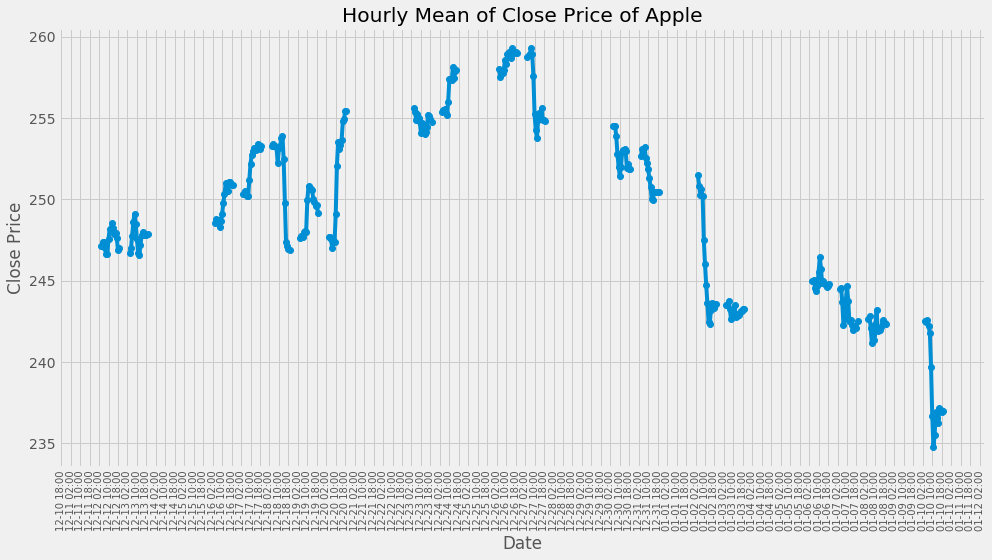

In [137]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator, DateFormatter
apple_df1 = apple_df.copy()
apple_df1.set_index('Datetime',inplace = True)
fig, ax = plt.subplots(figsize=(14, 8))
hourly_mean = apple_df1['Close'].resample('h').mean()
# Plot your resampled data
ax.plot(hourly_mean.index, hourly_mean, marker='o')
ax.set_title('Hourly Mean of Close Price of Apple')

# Set ticks every 12 hours
ax.xaxis.set_major_locator(HourLocator(interval=8))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))

# Manually control label rotation and fontsize
ax.tick_params(axis='x', labelrotation=90, labelsize=10)

# NO fig.autofmt_xdate() call here
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

plt.tight_layout()  # Prevent cutting off the rotated labels
plt.show()


## Plotting Weekly mean

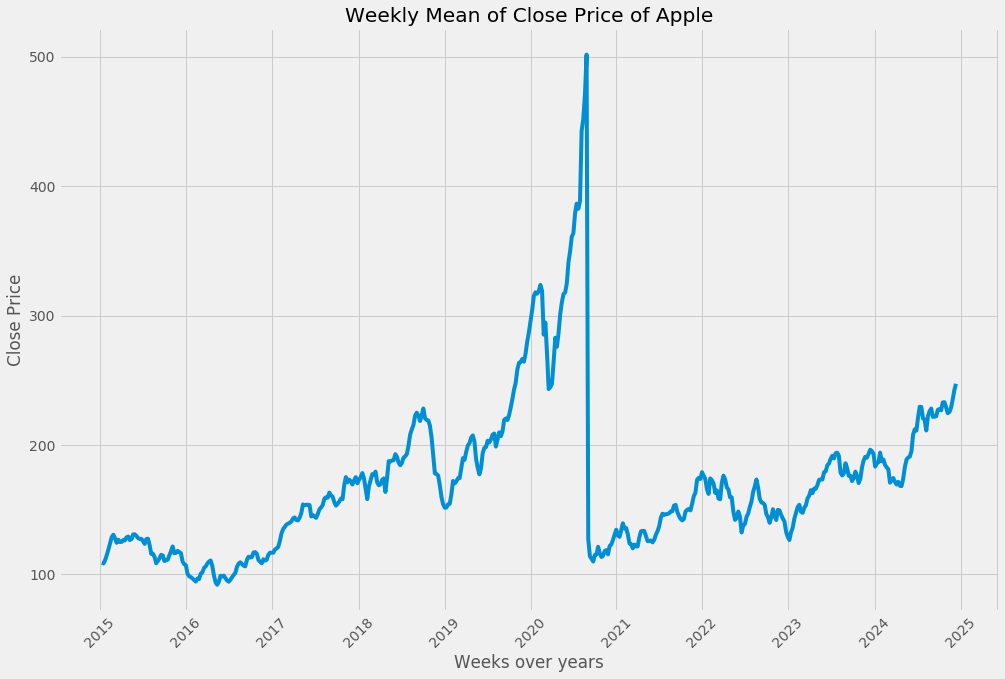

In [138]:
apple_intra_df_copy = apple_intra_df.copy()
plt.figure(figsize = (15,10))
apple_intra_df_copy.set_index('Datetime',inplace = True)
apple_intra_df_copy['Close_daily'].resample('W').mean().plot()
plt.title('Weekly Mean of Close Price of Apple')
plt.xticks(rotation = 45)
plt.xlabel('Weeks over years')
plt.ylabel('Close Price');

## Plotting Weather change in Israel

Text(0.5,1,'Weather Change in Israel over time')

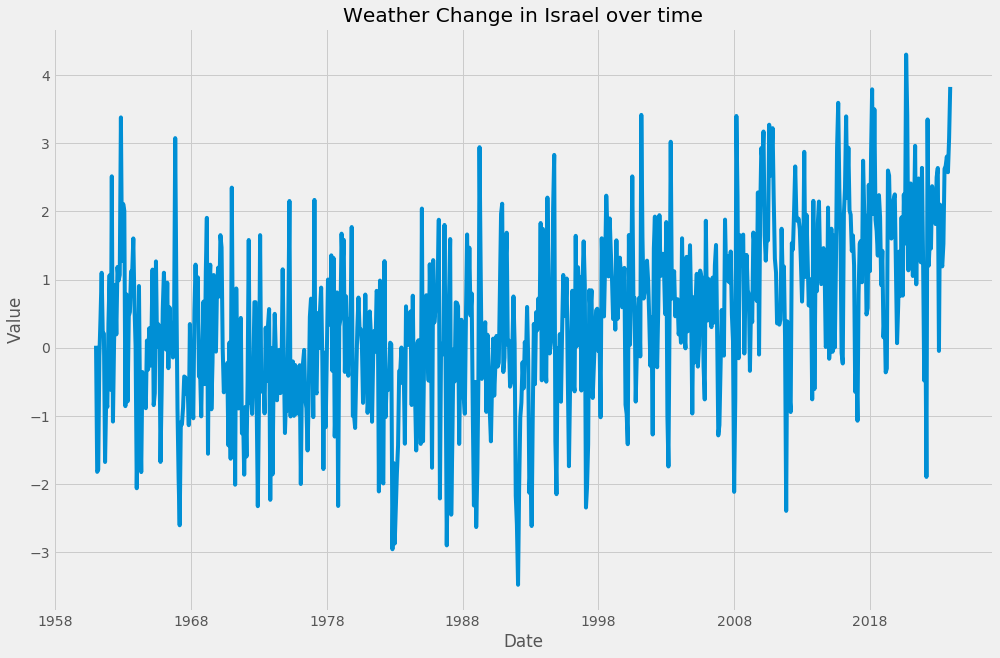

In [139]:
plt.figure(figsize = (15,10))
sns.lineplot(x = isr_df.Date, y = isr_df['Value'])
plt.title('Weather Change in Israel over time')


In [140]:
## Preprocessing for Prophet

train_subset = train_subset.reset_index().rename(columns={'Datetime':'ds',
                     'Close':'y'})

test_subset = test_subset.reset_index().rename(columns={'Datetime':'ds',
                     'Close':'y'})

train_subset_intra = train_subset_intra.reset_index().rename(columns={'Datetime':'ds',
                     'Return':'y'})

test_subset_intra = test_subset_intra.reset_index().rename(columns={'Datetime':'ds',
                     'Return':'y'})

train_weather = isr_train_subset.reset_index().rename(columns={'Date':'ds',
                     'Value':'y'})
test_weather = isr_test_subset.reset_index().rename(columns={'Date':'ds',
                     'Value':'y'})


## Hourly Apple model

In [141]:
%%time
model_apple= Prophet(yearly_seasonality = False)
model_apple.fit(train_subset)

CPU times: user 31.8 s, sys: 62.4 ms, total: 31.9 s
Wall time: 31.7 s


In [142]:
apple_preds = model_apple.predict(test_subset)

## Daily Apple Model

In [143]:
%%time
model_apple_intra = Prophet(daily_seasonality = True)
model_apple_intra.fit(train_subset_intra)

CPU times: user 239 ms, sys: 3.44 ms, total: 243 ms
Wall time: 241 ms


In [144]:
apple_preds_intra = model_apple_intra.predict(test_subset_intra)

In [145]:
apple_test.set_index('Datetime',inplace = True)
apple_test_intra.set_index('Datetime',inplace = True)

In [146]:
test_weather.head()

,index,ds,y
0,83047,2014-08-01,1.463
1,83048,2014-09-01,1.120
2,83049,2014-10-01,0.013
3,83050,2014-11-01,0.111
4,83051,2014-12-01,2.058


## Weather Model

In [147]:
%%time
model_weather = Prophet(weekly_seasonality = True, daily_seasonality = True)
model_weather.fit(train_weather)

CPU times: user 93.9 ms, sys: 367 µs, total: 94.2 ms
Wall time: 93.6 ms


In [148]:
weather_preds = model_weather.predict(test_weather)

# Plotting Apple Hourly stock

## Model Components

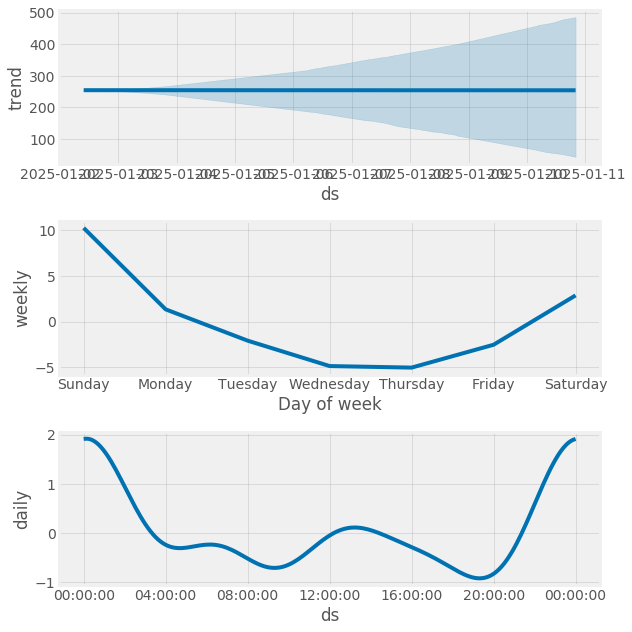

In [149]:
fig = model_apple.plot_components(apple_preds)
plt.show()

## Forecast

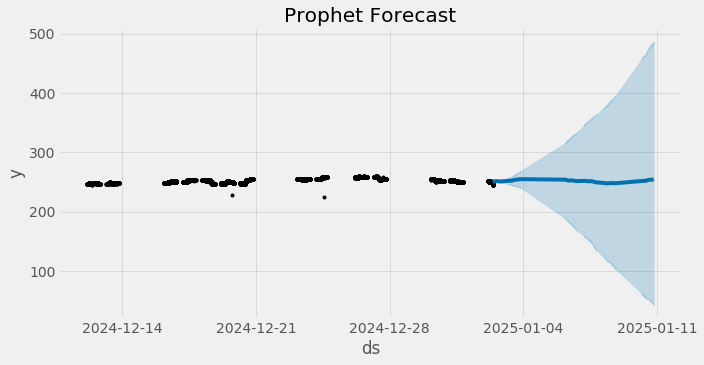

In [150]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_apple.plot(apple_preds, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Real Close values vs predicted values

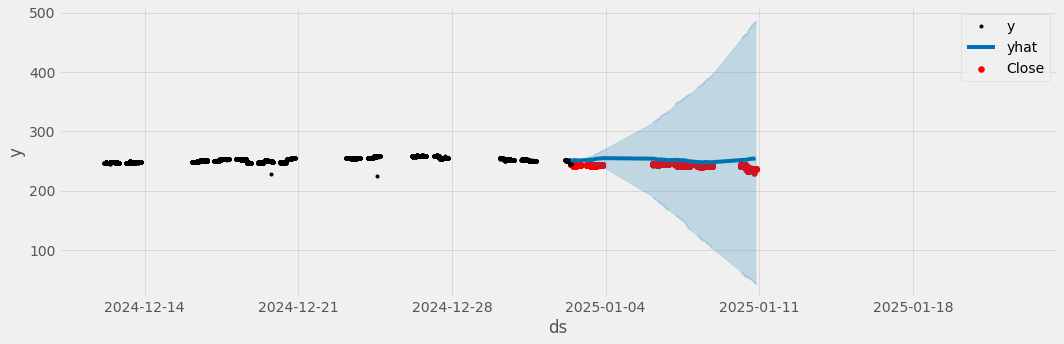

In [151]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test.index, apple_test['Close'], color = 'r')
fig = model_apple.plot(apple_preds, ax=ax)
plt.legend()


In [152]:
train_subset.loc[len(train_subset)-1]['ds']

Timestamp('2025-01-02 09:43:00')

## Focusing on specific interval

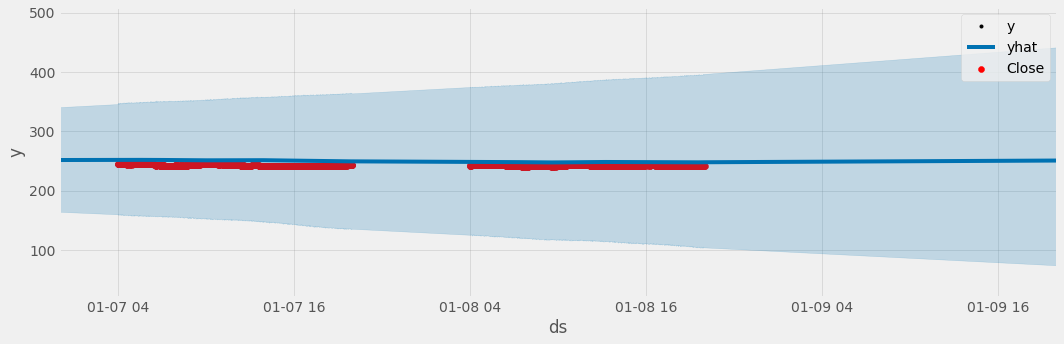

In [153]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test.index, apple_test['Close'], color = 'r')
fig = model_apple.plot(apple_preds, ax=ax)
ax.set_xbound(lower='01-07-2025',
              upper='2025-01-09 20')
plt.legend()


## Future predictions

In [154]:
future = model_apple.make_future_dataframe(periods=1000, freq='min', include_history=False)
forecast = model_apple.predict(future)

In [155]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
995,2025-01-03 02:19:00,254.609486,248.938690,256.496214,250.789831,258.278980,-1.725322,-1.725322,-1.725322,0.685532,0.685532,0.685532,-2.410854,-2.410854,-2.410854,0.0,0.0,0.0,252.884164
996,2025-01-03 02:20:00,254.609463,248.991565,256.644480,250.785345,258.284281,-1.737750,-1.737750,-1.737750,0.672156,0.672156,0.672156,-2.409906,-2.409906,-2.409906,0.0,0.0,0.0,252.871713
997,2025-01-03 02:21:00,254.609440,248.633831,256.816918,250.780859,258.293263,-1.750139,-1.750139,-1.750139,0.658818,0.658818,0.658818,-2.408957,-2.408957,-2.408957,0.0,0.0,0.0,252.859301
998,2025-01-03 02:22:00,254.609417,249.108271,256.777617,250.776374,258.302246,-1.762485,-1.762485,-1.762485,0.645519,0.645519,0.645519,-2.408005,-2.408005,-2.408005,0.0,0.0,0.0,252.846932
999,2025-01-03 02:23:00,254.609394,248.679129,256.331562,250.771888,258.311228,-1.774788,-1.774788,-1.774788,0.632262,0.632262,0.632262,-2.407051,-2.407051,-2.407051,0.0,0.0,0.0,252.834606


## Plotting Apple Daily stock

## Model compomemts

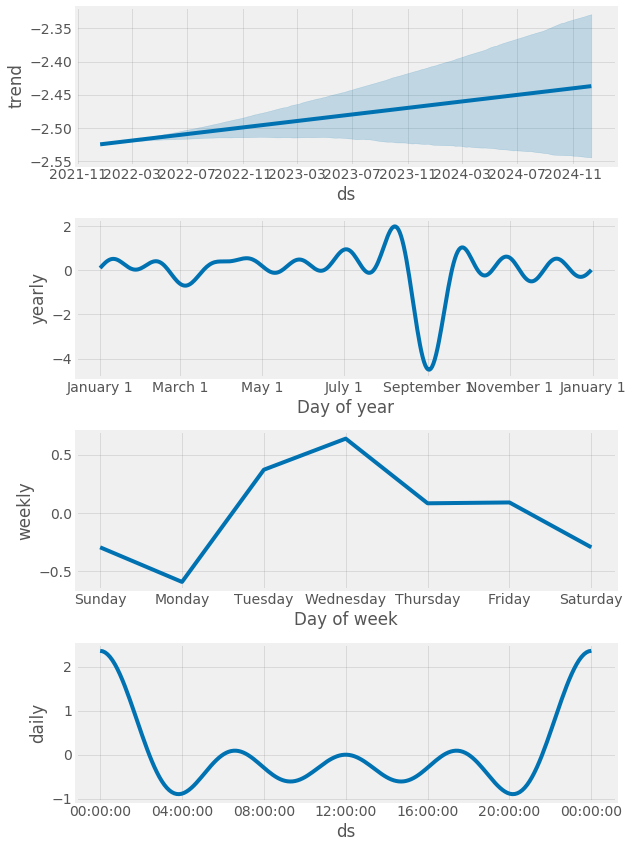

In [156]:
fig = model_apple_intra.plot_components(apple_preds_intra)
plt.show()

## Forecast

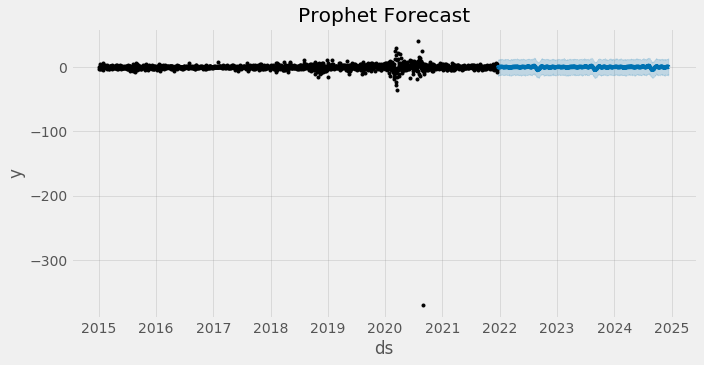

In [157]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Real Return values vs predicted Returns

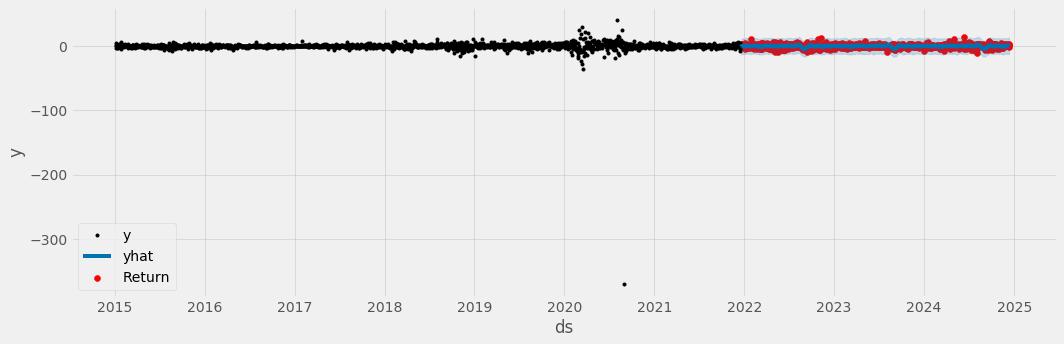

In [158]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Return'], color = 'r')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
plt.legend()

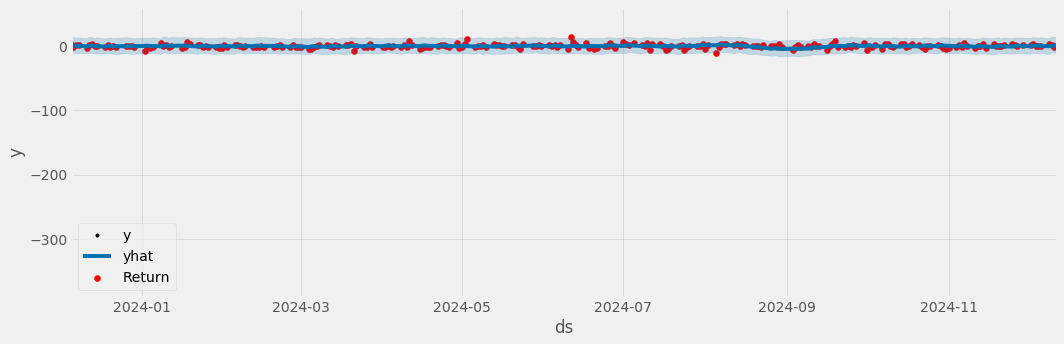

In [159]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Return'], color = 'r')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_xbound(lower='12-05-2023',
              upper='2024-12-12')
plt.legend()

## Future Predictions

In [160]:
future_intra = model_apple_intra.make_future_dataframe(periods=365*5, freq='d', include_history=False)
forecast_intra = model_apple_intra.predict(future_intra)

In [161]:
forecast_intra.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1820,2026-12-12,-2.378052,-12.117688,12.353176,-2.609521,-2.128976,2.337993,2.337993,2.337993,2.361024,2.361024,2.361024,-0.295128,-0.295128,-0.295128,0.272097,0.272097,0.272097,0.0,0.0,0.0,-0.040059
1821,2026-12-13,-2.377971,-11.775951,12.647223,-2.609711,-2.128689,2.268950,2.268950,2.268950,2.361024,2.361024,2.361024,-0.295128,-0.295128,-0.295128,0.203054,0.203054,0.203054,0.0,0.0,0.0,-0.109021
1822,2026-12-14,-2.377891,-12.902553,11.347128,-2.609887,-2.128403,1.899986,1.899986,1.899986,2.361024,2.361024,2.361024,-0.592347,-0.592347,-0.592347,0.131309,0.131309,0.131309,0.0,0.0,0.0,-0.477905
1823,2026-12-15,-2.377810,-10.824885,12.498503,-2.610063,-2.128077,2.791400,2.791400,2.791400,2.361024,2.361024,2.361024,0.371292,0.371292,0.371292,0.059085,0.059085,0.059085,0.0,0.0,0.0,0.413590
1824,2026-12-16,-2.377729,-11.920206,12.046633,-2.610237,-2.127744,2.987828,2.987828,2.987828,2.361024,2.361024,2.361024,0.638215,0.638215,0.638215,-0.011411,-0.011411,-0.011411,0.0,0.0,0.0,0.610099


# Plotting Weather change in Israel

### Model Components

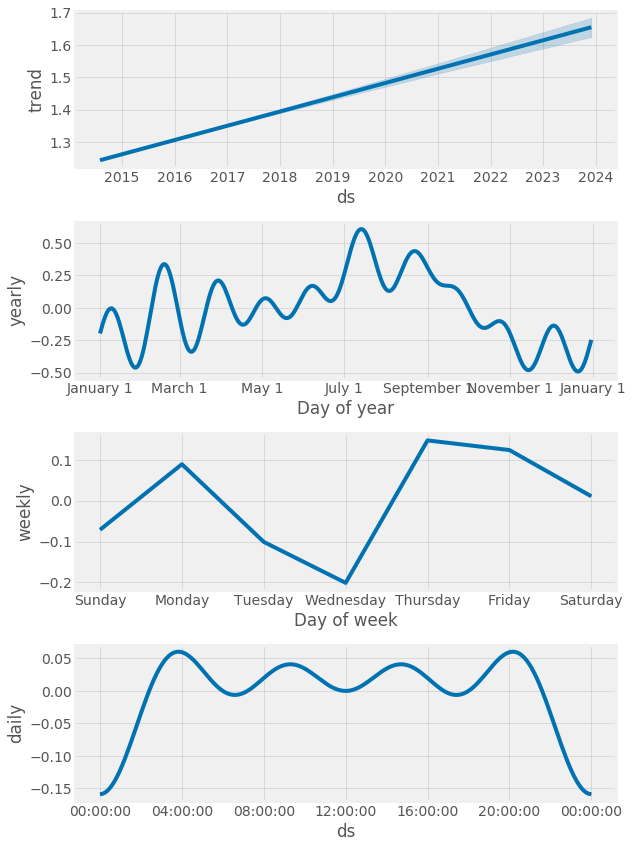

In [162]:
fig = model_weather.plot_components(weather_preds)
plt.show()

### Forecast

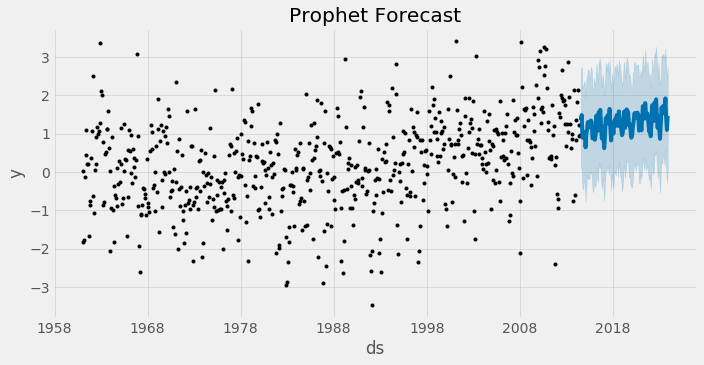

In [163]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_weather.plot(weather_preds, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

### Real change vs Predicted

In [164]:
isr_test_subset.set_index('Date',inplace = True)

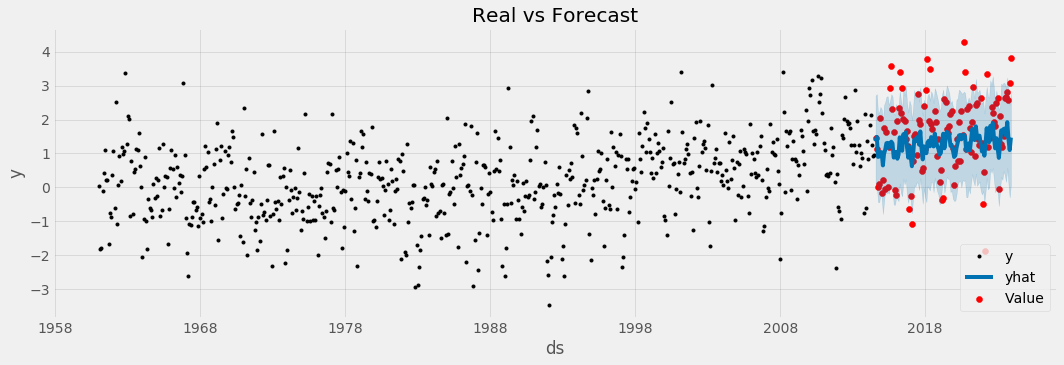

In [165]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(isr_test_subset.index, isr_test_subset['Value'], color = 'r')
fig = model_weather.plot(weather_preds, ax=ax)
plt.title('Real vs Forecast')
plt.legend()


### Only on the test period

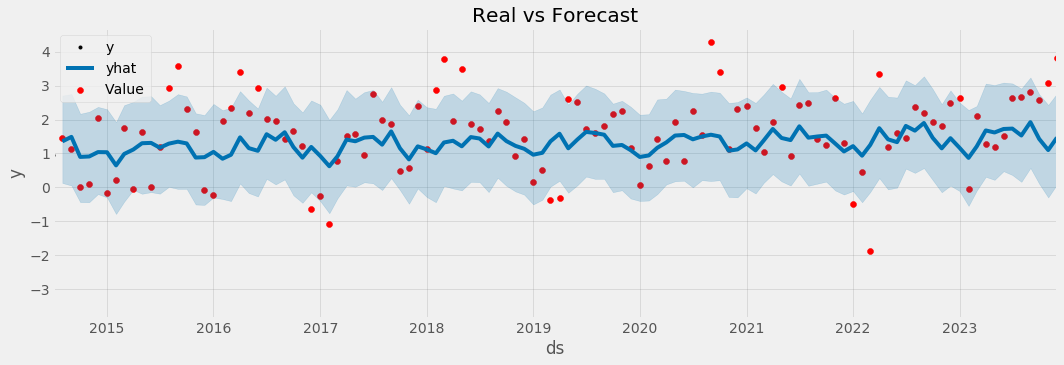

In [166]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(isr_test_subset.index, isr_test_subset['Value'], color = 'r')
fig = model_weather.plot(weather_preds, ax=ax)
ax.set_xbound(lower='2014-07-01',
              upper='2023-12-01')
plt.title('Real vs Forecast')
plt.legend()

In [167]:
future = model_weather.make_future_dataframe(periods=120, freq='m', include_history=False)
forecast = model_weather.predict(future)

In [168]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
115,2024-02-29,1.665740,0.256719,2.929239,1.633738,1.700263,-0.052225,-0.052225,-0.052225,-0.158776,-0.158776,-0.158776,0.148087,0.148087,0.148087,-0.041537,-0.041537,-0.041537,0.0,0.0,0.0,1.613515
116,2024-03-31,1.669473,0.210267,2.964325,1.636741,1.704557,-0.026058,-0.026058,-0.026058,-0.158776,-0.158776,-0.158776,-0.071146,-0.071146,-0.071146,0.203864,0.203864,0.203864,0.0,0.0,0.0,1.643415
117,2024-04-30,1.673085,0.216079,2.800027,1.639785,1.708745,-0.203472,-0.203472,-0.203472,-0.158776,-0.158776,-0.158776,-0.100841,-0.100841,-0.100841,0.056145,0.056145,0.056145,0.0,0.0,0.0,1.469613
118,2024-05-31,1.676818,0.478883,3.073169,1.643040,1.712951,0.060779,0.060779,0.060779,-0.158776,-0.158776,-0.158776,0.124458,0.124458,0.124458,0.095098,0.095098,0.095098,0.0,0.0,0.0,1.737597
119,2024-06-30,1.680431,0.359911,3.007068,1.646202,1.716969,0.005535,0.005535,0.005535,-0.158776,-0.158776,-0.158776,-0.071146,-0.071146,-0.071146,0.235457,0.235457,0.235457,0.0,0.0,0.0,1.685965


# Evaluate


In [170]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_weather['y'],weather_preds['yhat'])
mse

1.1691460385267431